# Across scenario basic analysis

### Load packages

In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline

import scipy.stats
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
#display all columns
pd.set_option('display.max_columns', None)

## Theming

In [3]:
sns.set_style("white")

### Helper functions

In [4]:
#helper function for pd.agg
def item(x):
    """Returns representative single item"""
    return x.tail(1).item()

### Set up directory paths to plots and data

In [5]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

## Load in data

Assumes exported csvs from `basic_analysis.ipynb` in results folder

In [6]:
studies = [
    "drop_pilot",
    "collision_pilot",
    "rollingsliding_pilot",
    "dominoes_pilot",
    "clothiness_pilot",
    "towers_pilot",
    "linking_pilot",
    "containment_pilot",
]

In [22]:
ls `echo $csv_dir/'humans'`

human_accuracy-clothiness_pilot-production_2_testing.csv
human_accuracy-collision_pilot-production_2_testing.csv
human_accuracy-containment_pilot-production_2_testing.csv
human_accuracy-dominoes_pilot-production_1_testing.csv
human_accuracy-drop_pilot-production_2_testing.csv
human_accuracy-linking_pilot-production_2_testing.csv
human_accuracy-rollingsliding_pilot-production_2_testing.csv
human_accuracy-towers_pilot-production_2_testing.csv
human_responses-clothiness_pilot-production_2_testing.csv
human_responses-collision_pilot-production_2_testing.csv
human_responses-containment_pilot-production_2_testing.csv
human_responses-dominoes_pilot-production_1_testing.csv
human_responses-drop_pilot-production_2_testing.csv
human_responses-linking_pilot-production_2_testing.csv
human_responses-rollingsliding_pilot-production_2_testing.csv
human_responses-towers_pilot-production_2_testing.csv


In [45]:
#load all experiments as one dataframe
prefix = "human_responses-"
suffix = lambda s: "-production_%d_testing" % (1 if 'dominoes' in s else 2)
make_fname = lambda s: prefix + s + suffix(s) + ".csv"
df = []
for l in studies:
    _df = pd.read_csv(os.path.join(csv_dir, 'humans', make_fname(l)))
    if 'study' not in _df.columns:
        _df = _df.assign(study=[l] * len(_df), axis=0)
    df.append(_df)
df = pd.concat(df)
# df = pd.concat([pd.read_csv(os.path.join(csv_dir, 'humans', make_fname(l))) for l in studies])
print("Loaded dataframes")

Loaded dataframes


In [46]:
df['study']

0               drop_pilot
1               drop_pilot
2               drop_pilot
3               drop_pilot
4               drop_pilot
               ...        
15145    containment_pilot
15146    containment_pilot
15147    containment_pilot
15148    containment_pilot
15149    containment_pilot
Name: study, Length: 120450, dtype: object

In [47]:
#save nice scenario name
df['scenario'] = df['study'].apply(lambda x: x.split('_')[0])

In [48]:
#sort by it
df.sort_values('scenario',inplace=True)

In [49]:
#subtract stimulus presentation time from reaction time
df['rt'] = df['rt'] - 2500

In [50]:
#drop reaction times longer than 10 seconds
df['rt'] = df['rt'].apply(lambda x: x if x < 10000 else np.nan)

In [51]:
def outcome_helper(correct,response):
    response = response == "YES"
    if correct and response: return "hit"
    if not correct and response: return "false_alarm"
    if correct and not response: return "correct_rejection"
    if not correct and not response: return "miss"

In [52]:
#encode response kind
df['outcome'] = [outcome_helper(correct, response) for correct, response in zip(df['correct'],df['response'])]

In [53]:
df['outcome'].value_counts()

hit                  46011
correct_rejection    43379
false_alarm          16846
miss                 14214
Name: outcome, dtype: int64

## Plots

### Per stimulus

In [54]:
df['response'] = df['response'] == "YES" #encode response as boolean

In [63]:
df['c'] = 1

In [130]:
per_stim_agg = df.groupby('stim_ID').agg({
    'scenario' : lambda s: s.head(1),
    'correct' : lambda cs: np.mean([1 if c == True else 0 for c in cs]),
    'response' : 'mean',
    'c' : 'count',
    'stim_url' : lambda s: s.head(1),
    'hdf5_url' : lambda s: s.head(1)
})
per_stim_agg.sort_values('scenario',inplace=True)

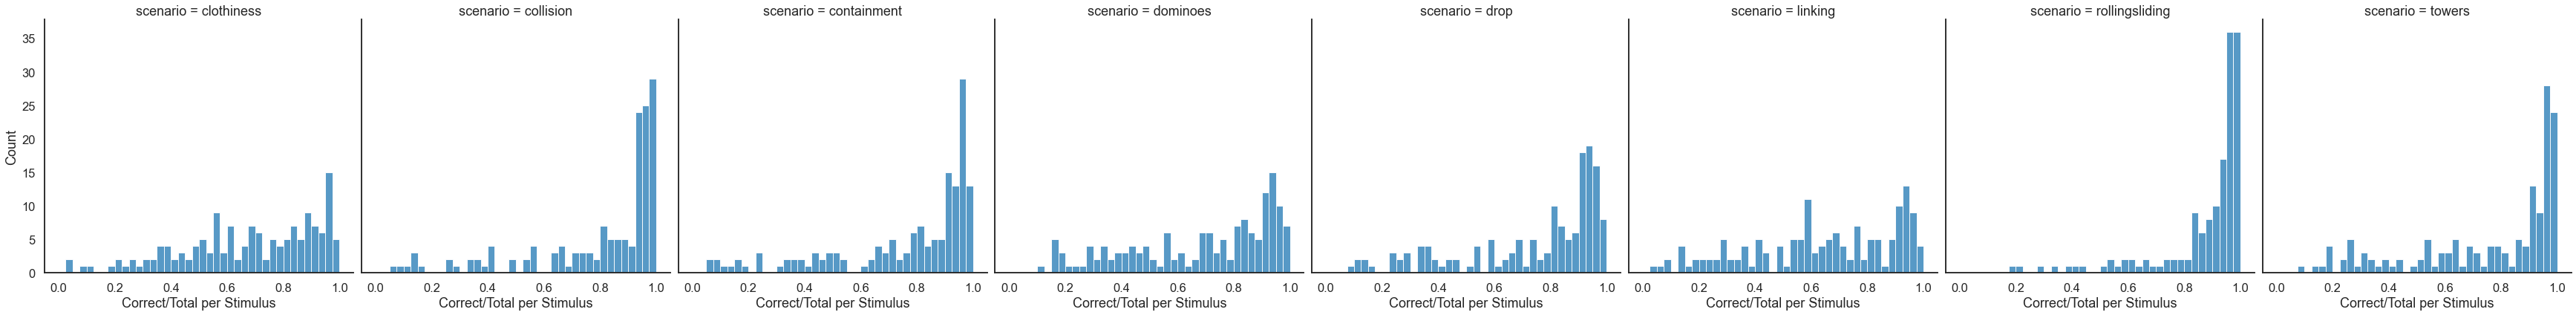

In [66]:
g = sns.FacetGrid(per_stim_agg, col="scenario", height=6)
g.map(sns.histplot, "correct", bins=40, binrange=[0,1])
g.set_axis_labels("Correct/Total per Stimulus","Count")
# g.savefig(os.path.join(plot_dir,"per_stim_16.pdf"))

Individual plots

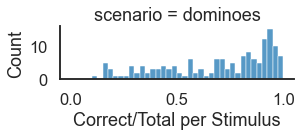

In [67]:
scenario = "dominoes"

g = sns.FacetGrid(per_stim_agg.query("scenario == @scenario"), col="scenario", height=2, aspect=2)
g.map(sns.histplot, "correct", bins=40, binrange=[0,1])
g.set_axis_labels("Correct/Total per Stimulus","Count")
# g.savefig(os.path.join(plot_dir,"per_stim_"+scenario+".pdf"))

In [68]:
per_stim_agg.query("scenario == @scenario")

,scenario,correct,response,c,stim_url
stim_ID,,,,,
pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0029_img,dominoes,0.98,0.98,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0007_img,dominoes,0.74,0.74,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0008_img,dominoes,0.42,0.58,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0012_img,dominoes,0.91,0.09,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0014_img,dominoes,0.81,0.81,100,https://human-physics-benchmarking-dominoes-pi...
...,...,...,...,...,...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0023_img,dominoes,0.68,0.32,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0024_img,dominoes,0.72,0.28,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0025_img,dominoes,0.87,0.13,100,https://human-physics-benchmarking-dominoes-pi...


### Per person

do people have a bias for yes or no?

In [69]:
per_person_agg = df.groupby('gameID').agg({
    'scenario' : lambda s: s.head(1),
    'correct' : lambda cs: np.mean([1 if c == True else 0 for c in cs]),
    'response' : 'mean',
    'c' : 'count',
})
per_person_agg.sort_values('scenario',inplace=True)

What is the mean correctness for the guesses of a single participant?

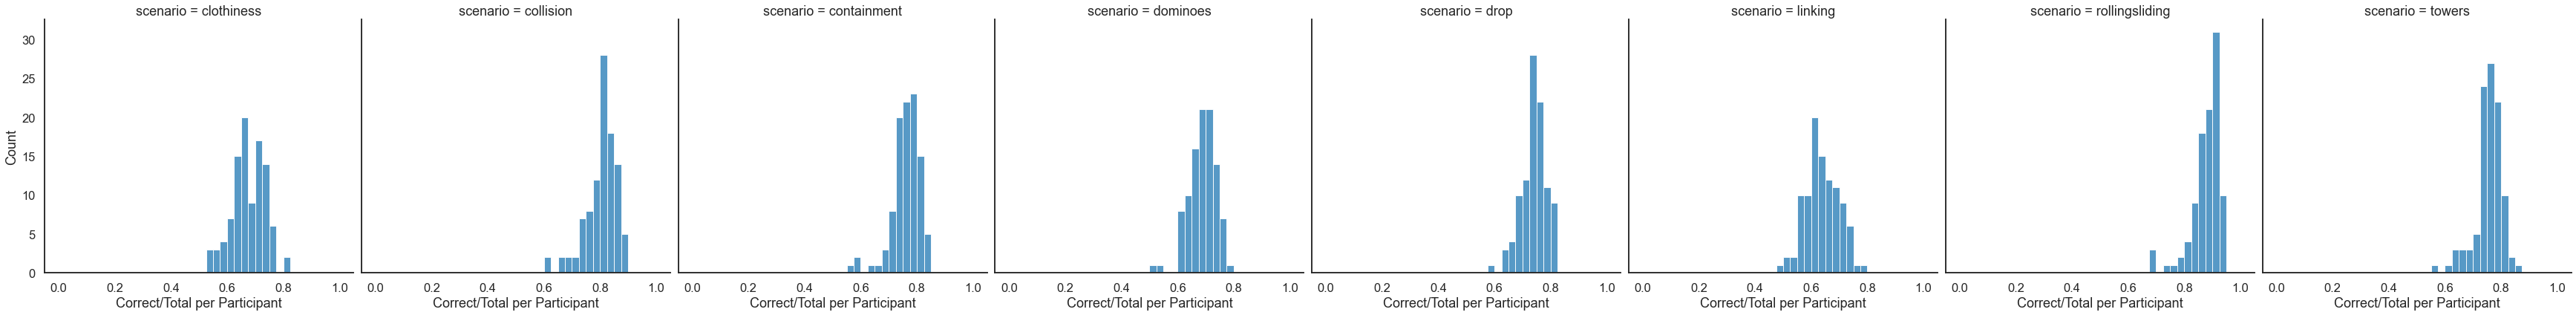

In [70]:
g = sns.FacetGrid(per_person_agg, col="scenario", height=6)
g.map(sns.histplot, "correct", bins=40, binrange=[0,1])
g.set_axis_labels("Correct/Total per Participant","Count")
# g.savefig(os.path.join(plot_dir,"per_subject_16.pdf"))

What is the Yes/No bias for each person? 1 corresponds to Yes. Perfect guesses every time would mean a response of 0.5

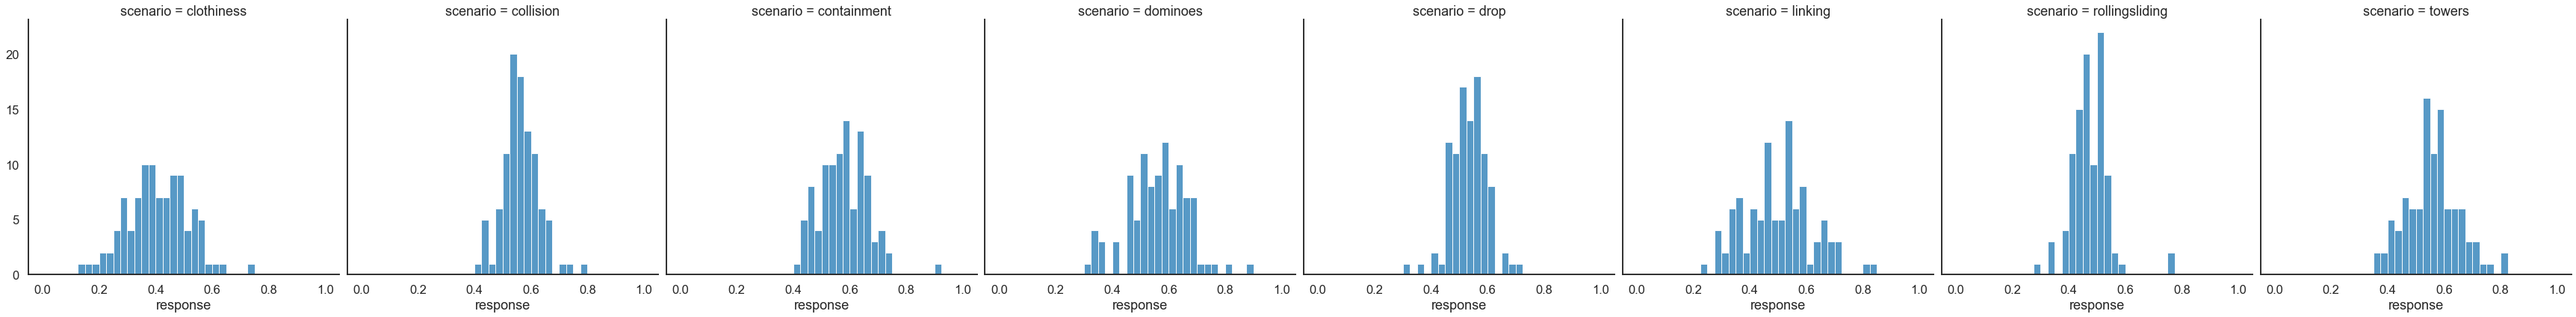

In [71]:
g = sns.FacetGrid(per_person_agg, col="scenario", height=6)
g.map(sns.histplot, "response", bins=40, binrange=[0,1])

In [72]:
df.groupby('scenario').agg({'response':'mean'})

,response
scenario,
clothiness,0.405933
collision,0.562133
containment,0.578416
dominoes,0.560733
drop,0.532267
linking,0.499600
rollingsliding,0.475733
towers,0.558693


### Per guess

What is the distribution of reaction times? This does not include the 2500ms it takes for the stimulus to be shown, where the buttons become available only afterwards

In [ ]:
g = sns.FacetGrid(df, col="scenario", hue="correct", height=6)
g.map(sns.histplot, "rt", bins=40, binrange=[0,10000])
g.add_legend()

In [ ]:
g = sns.FacetGrid(df, col="scenario", hue="correct", height=6)
g.map(sns.violinplot, "correct","rt", order=[True,False])

In [ ]:
g = sns.FacetGrid(df, col="scenario", hue="outcome", height=6)
g.map(sns.violinplot, "outcome","rt", order=["hit","correct_rejection","miss","false_alarm"])

### General

What is the d-prime of the experiment?

### Easy & adversarial example cases
> Easy, hard, chance, adversarial; reliable, noisy

In [184]:
import h5py
import cv2
from PIL import Image

def download_stims(stims, suffix='mp4'):
    if suffix == 'mp4':
        key, _dir = 'stim_url', 'mp4s'
    elif suffix == 'hdf5':
        key, _dir = 'hdf5_url', 'hdf5s'
    elif suffix == 'map':
        key, _dir = 'map_url', 'maps'
    else:
        raise NotImplementedError(suffix)

    p = !pwd
    p = p[0]
    files = []
    for i in range(len(stims)):
        url = selection[key][i]
        fname = url.split('/')[-1]
        outname = os.path.join(p, _dir, fname)
        if not os.path.exists(outname):
            !wget `echo $url` -O `echo $outname`
        else:
            print("%s already exists" % fname)
        files.append(outname)
    return files
    
def get_frame_mp4(fname, frame_num=0):
    assert fname[-4:] == '.mp4', fname
    cap = cv2.VideoCapture(fname)
    if (cap.isOpened() == False):
        print("Error opening video stream")
    
    count = -1
    frame = None
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            count += 1            
        else:
            break
        
        if count == frame_num:
            break
            
    cap.release()
    cv2.destroyAllWindows()
    return frame

def get_frame_hdf5(fname, frame_num=0, imkey='_img'):
    
    assert fname [-5:] == '.hdf5', fname
    f = h5py.File(fname)
    frames = sorted(list(f['frames'].keys()))
    images = f['frames'][frames[frame_num]]['images']
    im = images[imkey]
    try:
        im = Image.open(io.BytesIO(im[:]))    
    except:
        im = np.array(im)
    f.close()
    return np.array(im)

pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0015_img.mp4 already exists
pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_0007_img.mp4 already exists
pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_0012_img.mp4 already exists


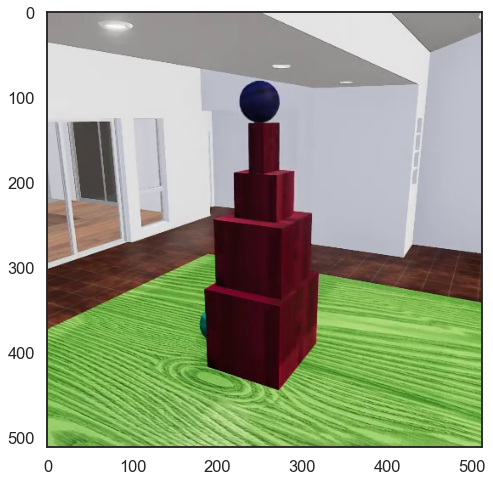

In [186]:
mp4s = download_stims(selection, 'mp4')
arr = get_frame_mp4(mp4s[0], 100)
arr = np.stack([arr[...,c] for c in [2,1,0]], -1)
fig, axes = plt.subplots(1, figsize=(8,8))
axes.imshow(arr)
plt.show()

pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0015.hdf5 already exists


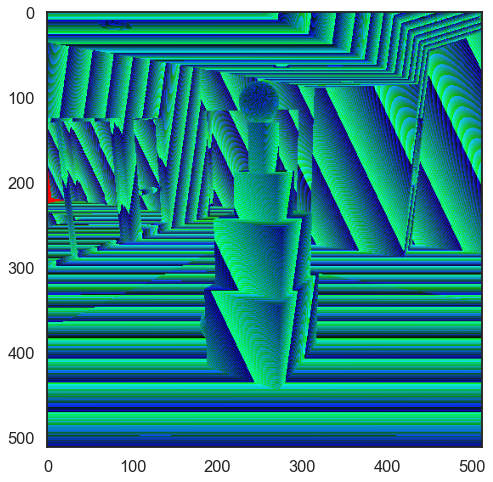

In [191]:
hdf5s = download_stims(selection[0:1], 'hdf5')
arr = get_frame_hdf5(hdf5s[0], 100, imkey='_depth')
# arr = np.stack([arr[...,c] for c in [2,1,0]], -1)
fig, axes = plt.subplots(1, figsize=(8,8))
axes.imshow(arr)
plt.show()

In [135]:
num_stims = 3

for scenario in per_stim_agg['scenario'].unique():
    print("*****",scenario,"*****")
    df_s = per_stim_agg[per_stim_agg['scenario'] == scenario]
    df_s = df_s.sort_values('correct')
    #get easy stims
    selection = df_s[df_s['correct']>0.90].sample(num_stims)
    print("---- Easy stims ----")
    display(selection)
    print(list(selection['stim_url']),"\n")
    #get hard stims
    selection = df_s[(df_s['correct']>0.70) & (df_s['correct']<0.80)].sample(num_stims)
    print("---- Hard stims ----")
    display(selection)
    print(list(selection['stim_url']),"\n")
    #get chance stims
    selection = df_s[(df_s['correct']>0.45) & (df_s['correct']<0.55)].sample(num_stims)
    print("---- Chance stims ----")
    display(selection)
    print(list(selection['stim_url']),"\n")
    #get adversarial stims
#     selection = df_s[df_s['correct']<0.20].sample(num_stims)
    selection = df_s.head(num_stims)
    print("---- Adversarial stims ----")
    display(selection)
    print(list(selection['stim_url']),"\n")

***** clothiness *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
test19_0005_img,clothiness,0.97,0.03,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...
test15_0016_img,clothiness,0.96,0.96,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...
test12_0007_img,clothiness,0.97,0.97,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...


['https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test19_0005_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test15_0016_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test12_0007_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
test14_0001_img,clothiness,0.71,0.71,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...
test16_0014_img,clothiness,0.72,0.28,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...
test16_0006_img,clothiness,0.79,0.79,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...


['https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test14_0001_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test16_0014_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test16_0006_img.mp4'] 

---- Chance stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
test17_0003_img,clothiness,0.52,0.52,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...
test18_0015_img,clothiness,0.50,0.50,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...
test18_0004_img,clothiness,0.53,0.47,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...


['https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test17_0003_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test18_0015_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test18_0004_img.mp4'] 

---- Adversarial stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
test15_0017_img,clothiness,0.04,0.04,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...
test18_0014_img,clothiness,0.04,0.04,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...
test14_0014_img,clothiness,0.09,0.09,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...


['https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test15_0017_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test18_0014_img.mp4', 'https://human-physics-benchmarking-clothiness-pilot.s3.amazonaws.com/test14_0014_img.mp4'] 

***** collision *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_collision_non-sphere_box_2_dis_2_occ_0004_img,collision,0.94,0.06,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...
pilot_it2_collision_assorted_targets_tdw_2_dis_2_occ_0006_img,collision,0.95,0.05,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...
pilot_it2_collision_non-sphere_box_0008_img,collision,0.96,0.96,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...


['https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_non-sphere_box_2_dis_2_occ_0004_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_assorted_targets_tdw_2_dis_2_occ_0006_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_non-sphere_box_0008_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_collision_tiny_ball_tdw_1_dis_1_occ_0004_img,collision,0.74,0.26,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...
pilot_it2_collision_assorted_targets_tdw_2_dis_2_occ_0000_img,collision,0.71,0.71,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...
pilot_it2_collision_assorted_targets_box_2_dis_2_occ_0004_img,collision,0.77,0.77,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...


['https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_tiny_ball_tdw_1_dis_1_occ_0004_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_assorted_targets_tdw_2_dis_2_occ_0000_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_assorted_targets_box_2_dis_2_occ_0004_img.mp4'] 

---- Chance stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_collision_yeet_tdw_2_dis_2_occ_0005_img,collision,0.53,0.53,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...
pilot_it2_collision_yeet_box_0005_img,collision,0.53,0.53,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...
pilot_it2_collision_yeet_tdw_1_dis_1_occ_0006_img,collision,0.49,0.51,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...


['https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_yeet_tdw_2_dis_2_occ_0005_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_yeet_box_0005_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_yeet_tdw_1_dis_1_occ_0006_img.mp4'] 

---- Adversarial stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_collision_non-sphere_box_1_dis_1_occ_0003_img,collision,0.05,0.95,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...
pilot_it2_collision_yeet_box_1_dis_1_occ_0005_img,collision,0.09,0.91,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...
pilot_it2_collision_yeet_box_2_dis_2_occ_0001_img,collision,0.11,0.89,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...


['https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_non-sphere_box_1_dis_1_occ_0003_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_yeet_box_1_dis_1_occ_0005_img.mp4', 'https://human-physics-benchmarking-collision-pilot.s3.amazonaws.com/pilot_it2_collision_yeet_box_2_dis_2_occ_0001_img.mp4'] 

***** containment *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot-containment-vase_0013_img,containment,0.940594,0.059406,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...
pilot-containment-cylinder-bowl_0010_img,containment,0.990099,0.990099,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...
pilot-containment-bowl_0009_img,containment,0.980198,0.019802,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...


['https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-vase_0013_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-cylinder-bowl_0010_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-bowl_0009_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot-containment-torus_0009_img,containment,0.722772,0.277228,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...
pilot-containment-bowl_0033_img,containment,0.782178,0.217822,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...
pilot-containment-box_0006_img,containment,0.722772,0.277228,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...


['https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-torus_0009_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-bowl_0033_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-box_0006_img.mp4'] 

---- Chance stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot-containment-bowl_0001_img,containment,0.524752,0.475248,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...
pilot-containment-cylinder-bowl_0008_img,containment,0.534653,0.534653,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...
pilot-containment-bowl_0027_img,containment,0.544554,0.455446,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...


['https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-bowl_0001_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-cylinder-bowl_0008_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-bowl_0027_img.mp4'] 

---- Adversarial stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot-containment-cone-plate_0017_img,containment,0.059406,0.940594,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...
pilot-containment-cone-plate_0007_img,containment,0.059406,0.940594,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...
pilot-containment-cone-plate_0005_img,containment,0.079208,0.920792,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...


['https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-cone-plate_0017_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-cone-plate_0007_img.mp4', 'https://human-physics-benchmarking-containment-pilot.s3.amazonaws.com/pilot-containment-cone-plate_0005_img.mp4'] 

***** dominoes *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0019_img,dominoes,0.94,0.94,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_4mid_boxroom_0006_img,dominoes,0.97,0.97,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0021_img,dominoes,0.91,0.91,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...


['https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0019_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_4mid_boxroom_0006_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0021_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0024_img,dominoes,0.72,0.28,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0013_img,dominoes,0.74,0.26,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0018_img,dominoes,0.77,0.77,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...


['https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_1mid_J025R45_o1full_tdwroom_0024_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0013_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_2mid_J025R30_tdwroom_0018_img.mp4'] 

---- Chance stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_dominoes_1mid_J025R45_boxroom_0020_img,dominoes,0.52,0.52,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0028_img,dominoes,0.49,0.51,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0010_img,dominoes,0.52,0.52,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...


['https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_1mid_J025R45_boxroom_0020_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0028_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_1mid_J025R45_o1full_tdwroom_0010_img.mp4'] 

---- Adversarial stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0015_img,dominoes,0.12,0.88,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0007_img,dominoes,0.16,0.84,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0020_img,dominoes,0.16,0.84,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...


['https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0015_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0007_img.mp4', 'https://human-physics-benchmarking-dominoes-pilot.s3.amazonaws.com/pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0020_img.mp4'] 

***** drop *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_drop_sidezone_box_0008_img,drop,0.96,0.04,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....
pilot_it2_drop_sidezone_box_2_dis_2_occ_0008_img,drop,0.95,0.95,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....
pilot_it2_drop_all_bowls_box_1_dis_1_occ_0001_img,drop,0.94,0.06,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....


['https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sidezone_box_0008_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sidezone_box_2_dis_2_occ_0008_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_all_bowls_box_1_dis_1_occ_0001_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0009_img,drop,0.75,0.25,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....
pilot_it2_drop_sizes_tdw_1_dis_1_occ_0000_img,drop,0.79,0.21,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....
pilot_it2_drop_sizes_tdw_2_dis_2_occ_0007_img,drop,0.73,0.27,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....


['https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0009_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sizes_tdw_1_dis_1_occ_0000_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sizes_tdw_2_dis_2_occ_0007_img.mp4'] 

---- Chance stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_drop_sidezone_box_0000_img,drop,0.50,0.50,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....
pilot_it2_drop_sidezone_box_2_dis_2_occ_0007_img,drop,0.47,0.53,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....
pilot_it2_drop_simple_tdw_2_dis_2_occ_0001_img,drop,0.53,0.47,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....


['https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sidezone_box_0000_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sidezone_box_2_dis_2_occ_0007_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_simple_tdw_2_dis_2_occ_0001_img.mp4'] 

---- Adversarial stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_drop_sidezone_tdw_2_dis_2_occ_0006_img,drop,0.08,0.92,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....
pilot_it2_drop_sidezone_tdw_2_dis_2_occ_0001_img,drop,0.10,0.90,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....
pilot_it2_drop_sidezone_box_1_dis_1_occ_0004_img,drop,0.11,0.89,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....


['https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sidezone_tdw_2_dis_2_occ_0006_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sidezone_tdw_2_dis_2_occ_0001_img.mp4', 'https://human-physics-benchmarking-drop-pilot.s3.amazonaws.com/pilot_it2_drop_sidezone_box_1_dis_1_occ_0004_img.mp4'] 

***** linking *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0018_img,linking,0.96,0.04,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...
pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0024_img,linking,0.98,0.02,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...
pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0023_img,linking,0.94,0.06,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...


['https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0018_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0024_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0023_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1_tdwroom_0024_img,linking,0.73,0.27,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...
pilot_linking_nl1-6_ms03-7_aCylcap_bCyl_tdwroom_0001_img,linking,0.72,0.72,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...
pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom_0023_img,linking,0.76,0.76,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...


['https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1_tdwroom_0024_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-6_ms03-7_aCylcap_bCyl_tdwroom_0001_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom_0023_img.mp4'] 

---- Chance stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0006_img,linking,0.53,0.47,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...
pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom_0005_img,linking,0.54,0.54,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...
pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1_tdwroom_0005_img,linking,0.53,0.47,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...


['https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-5_aNone_bCube_occ1_dis1_tdwroom_0006_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom_0005_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1_tdwroom_0005_img.mp4'] 

---- Adversarial stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom_0020_img,linking,0.04,0.96,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...
pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_0015_img,linking,0.07,0.07,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...
pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1_tdwroom_0021_img,linking,0.08,0.08,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...


['https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom_0020_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_0015_img.mp4', 'https://human-physics-benchmarking-linking-pilot.s3.amazonaws.com/pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1_tdwroom_0021_img.mp4'] 

***** rollingsliding *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_rollingSliding_simple_collision_box_1_dis_1_occ_0004_img,rollingsliding,0.98,0.02,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...
pilot_it2_rollingSliding_simple_ramp_box_1_dis_1_occ_0005_img,rollingsliding,0.91,0.91,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...
pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0011_img,rollingsliding,1.00,0.00,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...


['https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_collision_box_1_dis_1_occ_0004_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ramp_box_1_dis_1_occ_0005_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0011_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_rollingSliding_simple_collision_box_1_dis_1_occ_0008_img,rollingsliding,0.73,0.73,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...
pilot_it2_rollingSliding_simple_ledge_box_1_dis_1_occ_0010_img,rollingsliding,0.77,0.77,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...
pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0002_img,rollingsliding,0.78,0.22,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...


['https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_collision_box_1_dis_1_occ_0008_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ledge_box_1_dis_1_occ_0010_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0002_img.mp4'] 

---- Chance stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_rollingSliding_simple_ramp_box_1_dis_1_occ_0000_img,rollingsliding,0.53,0.47,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...
pilot_it2_rollingSliding_simple_collision_box_0005_img,rollingsliding,0.53,0.47,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...
pilot_it2_rollingSliding_simple_ledge_tdw_1_dis_1_occ_0010_img,rollingsliding,0.50,0.50,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...


['https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ramp_box_1_dis_1_occ_0000_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_collision_box_0005_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ledge_tdw_1_dis_1_occ_0010_img.mp4'] 

---- Adversarial stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_it2_rollingSliding_simple_ramp_box_2_dis_2_occ_0012_img,rollingsliding,0.18,0.18,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...
pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0002_img,rollingsliding,0.21,0.21,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...
pilot_it2_rollingSliding_simple_ramp_box_1_dis_1_occ_0002_img,rollingsliding,0.30,0.30,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...


['https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ramp_box_2_dis_2_occ_0012_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0002_img.mp4', 'https://human-physics-benchmarking-rollingsliding-pilot.s3.amazonaws.com/pilot_it2_rollingSliding_simple_ramp_box_1_dis_1_occ_0002_img.mp4'] 

***** towers *****
---- Easy stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0012_img,towers,0.941176,0.058824,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...
pilot_towers_nb2_fr015_SJ010_mono1_dis1_occ1_tdwroom_0016_img,towers,0.980392,0.980392,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...
pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_0019_img,towers,0.901961,0.098039,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...


['https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0012_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb2_fr015_SJ010_mono1_dis1_occ1_tdwroom_0016_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_0019_img.mp4'] 

---- Hard stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_0018_img,towers,0.784314,0.215686,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...
pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_0009_img,towers,0.715686,0.715686,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...
pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_0010_img,towers,0.745098,0.254902,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...


['https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_0018_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_0009_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_0010_img.mp4'] 

---- Chance stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_0016_img,towers,0.539216,0.539216,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...
pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0016_img,towers,0.539216,0.460784,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...
pilot_towers_nb4_SJ025_mono1_dis1_occ1_boxroom_0005_img,towers,0.480392,0.480392,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...


['https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_0016_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0016_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_SJ025_mono1_dis1_occ1_boxroom_0005_img.mp4'] 

---- Adversarial stims ----


,scenario,correct,response,c,stim_url,hdf5_url
stim_ID,,,,,,
pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0015_img,towers,0.078431,0.078431,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...
pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_0007_img,towers,0.137255,0.862745,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...
pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_0012_img,towers,0.166667,0.833333,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...


['https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0015_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_0007_img.mp4', 'https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_0012_img.mp4'] 



In [76]:
df['occluders'].iloc[3]

'[]'

## Saving out relevant data

In [ ]:
pd.DataFrame(df['sessionID'].unique()).to_csv(os.path.join(csv_dir,"sessionIDs.csv"))